In [2]:
import uproot as up
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
branch_names=['trilep_type',
              'lep_ID_0','lep_ID_1','lep_ID_2',
              'lep_Pt_0','lep_Pt_1','lep_Pt_2',
              'lep_E_0','lep_E_1','lep_E_2','Ptll01','Ptll02','Ptll12',
              'lep_Eta_0','lep_Eta_1','lep_Eta_2',
              'lep_Phi_0','lep_Phi_1','lep_Phi_2',
              'lep_isolationPflowLoose_0','lep_isolationPflowLoose_1','lep_isolationPflowLoose_2',
              'lep_Mtrktrk_atPV_CO_0','lep_Mtrktrk_atPV_CO_1','lep_Mtrktrk_atPV_CO_2',
              'lep_RadiusCO_0','lep_RadiusCO_1','lep_RadiusCO_2',
              'met_met','Mll01','Mll02','Mll12','best_Z_Mll','minOSSFMll','minOSMll',
              'DRll01','DRll02','DRll12',
              'HT','HT_lep','HT_jets','lead_jetPt','sublead_jetPt','lead_jetE','sublead_jetE',
              'nJets_OR','nJets_OR_DL1r_85','nTaus_OR_Pt25_RNN',
              'DRl1jmin','DRl0jmin','DRjjMax',
              'DRl0j0','DRl0j1','DRl1j0','DRl1j1','DRl2j0','DRl2j1','DRj0j1',
              'mj0j1','ml0j0','ml0j1','ml1j0','ml1j1','ml2j0','ml2j1']

signal_events = up.open("hhml_signal.root")['nominal']



ttbar_events = up.open("ttbar.root")['nominal']
#ttbar_events = up.open('ttbar-1.root')['nominal']


vv_events = up.open("vv.root")['nominal']
#vv_events = up.open('vv-1.root')['nominal']



df_signal = signal_events.pandas.df(branch_names)
df_ttbar = ttbar_events.pandas.df(branch_names)
df_vv    = vv_events.pandas.df(branch_names)

df_signal['class'] =0
df_ttbar['class'] =1
df_vv['class']=2

df_bkgrnd = df_ttbar.append(df_vv)
#df_bkgrnd = df_vv
df_bkgrnd = df_bkgrnd.loc[(df_bkgrnd['trilep_type']>0) & (df_bkgrnd['nTaus_OR_Pt25_RNN']==0)]
df_signal = df_signal.loc[(df_signal['trilep_type']>0) & (df_signal['nTaus_OR_Pt25_RNN']==0)]
df = df_signal.append(df_bkgrnd)

#branch_names.remove('trilep_type')


#vv_events.keys()

NameError: name 'up' is not defined

In [1]:
y_df = df.pop('class')

NameError: name 'df' is not defined

In [4]:
#import seaborn as sns
#df['label'] = "ttbar"
#df.loc[y_df==1,"label"]="HH"
#df.loc[y_df==2,"label"]="VV"
#df["answer"] = df['label'].astype('category')
#g = sns.pairplot(df.sample(200), vars=branch_names,hue='label', palette="Set2", height=3)

In [33]:
#Split the samples into test and train.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


#Reduce to the variables we weant to train on 

X_train,X_test,y_train,y_test = train_test_split(df[branch_names],y_df,test_size=0.3)
#test  = xgb.DMatrix(data=test[variables_for_train],feature_names=variables_for_train)

In [44]:
#param_dist = {'eta':0.1,'max_depth':10,'eval_metric':'error','objective':'binary:logistic', 'n_estimators':100}
param_dist = {'num_class':3,
              'eta':0.1,
              'max_depth':10,
              'eval_metric':'error',
              'eval_metric':'auc',
              'objective':'multi:softprob',
              #'objective':'multi:softmax',
              #'objective':'binary:logistic',
              'tree_method':'gpu_hist',
              'n_estimators':5}

num_trees = 100
clf = xgb.XGBModel(**param_dist)
clf.fit(X_train, y_train)
#y_pred = XGBclassifier.predict(X_test)
#print (X_train.shape,y_train.shape)

XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=1, eta=0.1, eval_metric='auc',
         gamma=0, gpu_id=0, importance_type='gain', interaction_constraints='',
         learning_rate=0.100000001, max_delta_step=0, max_depth=10,
         min_child_weight=1, missing=nan,
         monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
         n_estimators=5, n_jobs=0, num_class=3, num_parallel_tree=1,
         objective='multi:softprob', random_state=0, reg_alpha=0, reg_lambda=1,
         scale_pos_weight=None, subsample=1, tree_method='gpu_hist',
         validate_parameters=1, verbosity=None)

<Figure size 432x288 with 0 Axes>

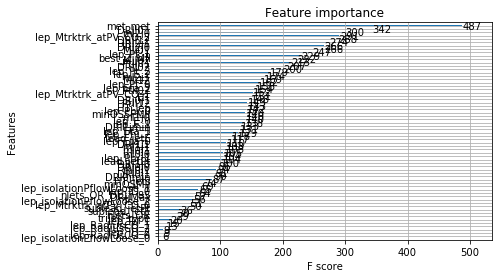

In [47]:
y_pred = clf.predict(X_test)
fig = plt.figure()
xgb.plot_importance(clf)#, ax=plt.gca())
fig.subplots_adjust(left=0.4)

161269 161269


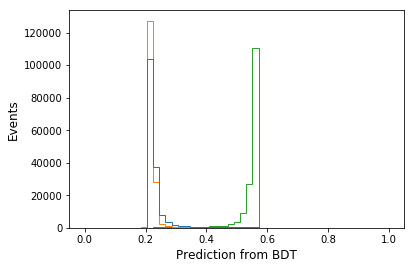

In [36]:
#Plot predictions
plt.figure()
plt.hist(y_pred,bins=np.linspace(0,1,50),histtype='step',label='All events')
plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events",fontsize=12)
print(len(y_test),len(y_pred))

In [11]:
!pip install hyperopt --user

     |████████████████████████████████| 972kB 14.6MB/s eta 0:00:01


In [12]:
#Hyper parameter optimization
#https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning
import pickle
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        #'n_estimators': 100,
        'n_estimators': hp.quniform('n_estimators', 10, 500, 1),
        'objective':hp.choice('objective',['multi:softprob','multi:softmax']),
        #'objective':hp.choice('objective',['binary:logistic','binary:hinge']),
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(num_class=3,
                    objective= space['objective'],
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),tree_method='gpu_hist')
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,eval_metric="merror",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [13]:
trials = Trials()

best_hyperparams = fmin(fn = objective,space = space,algo = tpe.suggest, max_evals = 100,trials = trials)


SCORE:                                                 
0.014593584031698493                                   
SCORE:                                                                              
0.014593584031698493                                                                
SCORE:                                                                              
0.014593584031698493                                                                
SCORE:                                                                              
0.014593584031698493                                                                
SCORE:                                                                              
0.014593584031698493                                                                
SCORE:                                                                              
0.014593584031698493                                                                
SCORE:                                

0.014593584031698493                                                                 
SCORE:                                                                               
0.014593584031698493                                                                 
SCORE:                                                                               
0.014593584031698493                                                                 
SCORE:                                                                               
0.014593584031698493                                                                 
SCORE:                                                                               
0.014593584031698493                                                                 
100%|██████████| 100/100 [03:57<00:00,  2.38s/trial, best loss: -0.014593584031698493]


In [15]:
best_hyperparams

{'colsample_bytree': 0.6392239950663533,
 'gamma': 6.412417779018628,
 'max_depth': 7.0,
 'min_child_weight': 5.0,
 'n_estimators': 119.0,
 'objective': 1,
 'reg_alpha': 168.0,
 'reg_lambda': 0.9743543257036683}

In [16]:
best_hyperparams['num_class'] = 3
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['n_estimators'] = int (best_hyperparams['n_estimators'])
best_hyperparams['tree_method'] = 'gpu_hist'
best_hyperparams['objective'] = "multi:softprob"
clf_opt = xgb.XGBModel(**best_hyperparams)
clf_opt.fit(X_train, y_train)

XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=0.6392239950663533,
         gamma=6.412417779018628, gpu_id=0, importance_type='gain',
         interaction_constraints='', learning_rate=0.300000012,
         max_delta_step=0, max_depth=7, min_child_weight=5.0, missing=nan,
         monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
         n_estimators=119, n_jobs=0, num_class=3, num_parallel_tree=1,
         objective='multi:softprob', random_state=0, reg_alpha=168.0,
         reg_lambda=0.9743543257036683, scale_pos_weight=None, subsample=1,
         tree_method='gpu_hist', validate_parameters=1, verbosity=None)

array([[0.06101419, 0.0105832 , 0.92840266],
       [0.08379415, 0.01127267, 0.90493315],
       [0.00978933, 0.00351011, 0.9867005 ],
       ...,
       [0.02952399, 0.00686197, 0.96361405],
       [0.02712014, 0.0087855 , 0.96409434],
       [0.00673802, 0.00535532, 0.9879067 ]], dtype=float32)

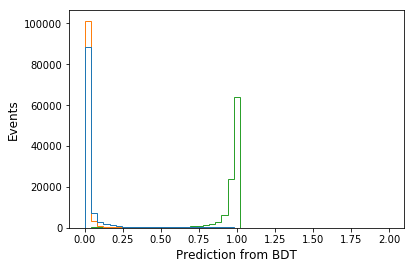

In [17]:
y_pred = clf_opt.predict(X_test)
#y_pred = clf_opt.predict(df_vv[branch_names])
#y_pred1 = clf_opt.predict(df_signal[branch_names])
#Plot predictions
plt.figure()
plt.hist(y_pred,bins=np.linspace(0,2,50),histtype='step',label='All events')
plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events",fontsize=12)
#confusion_matrix(y_test,(y_pred>0.2))
#print([x[0] for x in y_pred],[x[1] for x in y_pred])
y_pred

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
#print(classification_report(y_test, y_pred))


In [19]:
#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

#cv_clf = xgb.XGBClassifier(num_class=3,tree_method='gpu_hist')

#myParams = {
#    'min_child_weight':[1,5,10],
#    'learning_rate':[0.1,0.2,0.3,0.4,0.5],
#    'max_depth':[1,2,3,4,5,6,7,8,9,10],
#    'n_estimators':[10,100,120,150,200,250,300,350,400,500]
#}


#skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
#random_search = RandomizedSearchCV(cv_clf, 
#                                   param_distributions=myParams,
#                                   scoring='f1_macro',
#                                   n_jobs=10,
#                                   cv=skf.split(X_train,y_train),
#                                   verbose=1,random_state=1)

#random_search.fit(X_train,y_train)


In [20]:
import pickle
pickle.dump(clf_opt,open("multi_class.xgb","wb"))

In [31]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

In [26]:
#cm = confusion_matrix(y_test, y_pred)
#cm



In [30]:
#plot_confusion_matrix(cm, ['producer 1', 'producer 2', 'producer 3'])